<a href="https://colab.research.google.com/github/farghea/Pose-Detection-Biomechanics/blob/main/Application_II_asymetric_lifting_metrabs2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Due to the prevalence of asymmetric lifting in occupational activities at the workplace, we explored the feasibility and accuracy of estimating spinal loads and kinematics during such tasks. Here, a video from an experiment is analyzed using MeTRAbs. The video should be placed in your google drive: MyDrive/integrating new tech/validation/xavier test/mov.avi

Due to ethics limitations, we cannot put the video online. Please contcat me if you want it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Here metrabs is installed.

import tensorflow as tf
import tensorflow_hub as hub

model = hub.load('https://bit.ly/metrabs_l')  # Takes about 3 minutes

In [ ]:
# Import required libraries
import cv2
import os
import shutil
import numpy as np

# Delete the 'frames' directory if it exists, then create a new one
if os.path.exists('frames'):
    shutil.rmtree('frames')
os.makedirs('frames')

# Load the video clip
video_file = '/content/drive/MyDrive/integrating new tech/validation/xavier test/mov.avi'
cap = cv2.VideoCapture(video_file)

# Check if video is opened successfully
if not cap.isOpened():
    print("Error opening video file")

# Define the starting time in seconds
start_time = 14.5

# Calculate the starting frame number
fps = int(cap.get(cv2.CAP_PROP_FPS))
start_frame = start_time * fps

# Initialize frame_counter and time_list
frame_counter = 0
time_list = []

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    if frame_counter >= start_frame:
        frame_name = os.path.join('frames', f'frame_{frame_counter}.jpg')
        cv2.imwrite(frame_name, frame)
        time_list.append((frame_counter - start_frame) / fps)

    frame_counter += 1

# Release the video object and close all windows
cap.release()
cv2.destroyAllWindows()

# Convert time_list to a NumPy array
time_array = np.array(time_list)

# Print results
print(f"Start frame: {start_frame}")
print(f"Final frame: {frame_counter - 1}")
print("Time array (in seconds):")
# print(time_array)

print("\nFrames saved in the 'frames' directory.")

Start frame: 290.0
Final frame: 966
Time array (in seconds):

Frames saved in the 'frames' directory.


In [ ]:
for i in range(int(start_frame), frame_counter):
  # Read the jpg file
  image_file = f'/content/frames/frame_{i}.jpg'
  image = cv2.imread(image_file)

  # Check if the image is loaded successfully
  if image is None:
      print("Error opening image file")

  # Calculate the width of the cropped image
  cropped_width = int(image.shape[1] * 4/5)

  # Crop the left of the image
  cropped_image = image[:, :cropped_width, :]

  # Save the cropped image by overwriting the original image file
  cv2.imwrite(image_file, cropped_image)

print("Image cropped and saved successfully.")


Image cropped and saved successfully.


In [ ]:
joint_names = model.per_skeleton_joint_names['smpl+head_30'].numpy().astype(str)
joint_edges = model.per_skeleton_joint_edges['smpl+head_30'].numpy()


Flexion angle, assymtry angle, and shoulder to hand distance (horizontal) are calcualted from the pose estimation.


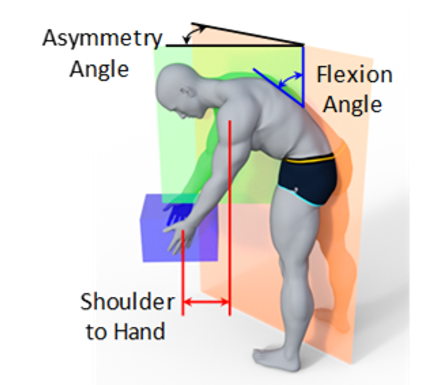

In [ ]:
import numpy as np

landmark_info = {
      'hip': [1, 2],
      'shoulder': [16, 17],
      'knee': [4, 5],
      'hand': [22, 23]}

def cal_mid_point(landmark_name, pred_pose):
  indx = landmark_info[landmark_name]
  pnt1 = pred_pose[indx[0], :]
  pnt2 = pred_pose[indx[1], :]
  mid_point = 0.5*(pnt1 + pnt2)
  return mid_point

def get_joint_point(landmark_name, pred_pose):
  indx = landmark_info[landmark_name]
  pnt1 = pred_pose[indx[0], :]
  pnt2 = pred_pose[indx[1], :]
  return np.vstack((pnt1, pnt2))


def estimate_3D_pose(jpg_file_name):
  myimg = tf.image.decode_image(tf.io.read_file(jpg_file_name))
  mypred = model.detect_poses(myimg, skeleton='smpl+head_30')

  pred_pose = mypred['poses3d'][0].numpy().reshape((30, 3))

  # lambda function to normalize a vector
  normalize = lambda vec: vec / np.linalg.norm(vec)

  # mid hip
  mid_hip = cal_mid_point('hip', pred_pose)

  # mid knee
  mid_knee = cal_mid_point('knee', pred_pose)

  # mid shoulder
  mid_shoulder = cal_mid_point('shoulder', pred_pose)

  # mid hand
  mid_hand = cal_mid_point('hand', pred_pose)

  # Shoulder length
  pnt1 = pred_pose[16, :]
  pnt2 = pred_pose[17, :]
  # pnt1 = pred_pose[1, :]
  # pnt2 = pred_pose[5, :]
  shoulder_length = np.linalg.norm(pnt2 - pnt1)
  # shoulder_length = 1

  # Flexion angle
  v1 = normalize(mid_shoulder - mid_hip)
  v2 = normalize(mid_hip - mid_knee)
  # v2 = np.array([0, -1, 0])
  flexion_angle = np.rad2deg(np.arccos(np.dot(v1, v2)))

  # hand to mid-hip distance (normalized to the shoulder distance)
  mid_hip_to_hand_distance = np.linalg.norm(mid_hand - mid_hip)/shoulder_length

  # hand to mid-hip distance (normalized to the shoulder distance)
  projection_matrix = np.array([1, 0, 1])
  mid_shoulder_to_hand_distance = np.linalg.norm(mid_hand*projection_matrix - mid_shoulder*projection_matrix)/shoulder_length

  # Asymmetry angle
  v1 = get_joint_point('shoulder', pred_pose)
  v2 = get_joint_point('hip', pred_pose)

  v1 = v1[0, :] - v1[1, :]
  v1[1] = 0
  v1 = v1/np.linalg.norm(v1)

  v2 = v2[0, :] - v2[1, :]
  v2[1] = 0
  v2 = v2/np.linalg.norm(v2)

  asymmetry_angle = np.rad2deg(np.arccos(np.dot(v1, v2)))

  return flexion_angle, mid_hip_to_hand_distance, asymmetry_angle, mid_shoulder_to_hand_distance



In [ ]:
def plot_results(image, pred, joint_names, joint_edges):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.patches import Rectangle

    plt.rcParams['font.size'] = 9
    fig = plt.figure(figsize=(18/2.54, 7/2.54))

    image_ax_no_pose = fig.add_subplot(1, 3, 1)
    image_ax_no_pose.imshow(image.numpy())

    image_ax = fig.add_subplot(1, 3, 2)
    image_ax.imshow(image.numpy())
    for x, y, w, h, c in pred['boxes'].numpy():
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    image_ax.set_xticklabels([])
    image_ax.set_yticklabels([])

    pose_ax = fig.add_subplot(1, 3, 3, projection='3d')
    pose_ax.view_init(0, 90)
    pose_ax.set_xlim3d(-1000+500, 1000+500)
    pose_ax.set_zlim3d(-1000, 1000)
    pose_ax.set_ylim3d(1500, 4500)

    poses3d = pred['poses3d'].numpy()
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, pred['poses2d'].numpy()):
        for i_start, i_end in joint_edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        image_ax.scatter(*pose2d.T, s=2)
        pose_ax.scatter(*pose3d.T, s=2)
    pose_ax.set_xticklabels([])
    pose_ax.set_yticklabels([])
    pose_ax.set_zticklabels([])

    return fig




In [ ]:
analysis_results = {
    'time':   [],
    'flex_pose':   [],
    'dist_pose':    [],
    'asymmetry_angle': [],
    'shoulder_hand_dist': []}

counter = 0
for i in range(int(start_frame) + 1, frame_counter, 2):
  print(i)
  myfile = f'/content/frames/frame_{i}.jpg'
  pose_estimation_parameters = estimate_3D_pose(myfile)

  analysis_results['time'].append(time_array[counter])
  analysis_results['flex_pose'].append(pose_estimation_parameters[0])
  analysis_results['dist_pose'].append(pose_estimation_parameters[1])
  analysis_results['asymmetry_angle'].append(pose_estimation_parameters[2])
  analysis_results['shoulder_hand_dist'].append(pose_estimation_parameters[3])


  counter = counter + 2





291
293
295
297
299
301
303
305
307
309
311
313
315
317
319
321
323
325
327
329
331
333
335
337
339
341
343
345
347
349
351
353
355
357
359
361
363
365
367
369
371
373
375
377
379
381
383
385
387
389
391
393
395
397
399
401
403
405
407
409
411
413
415
417
419
421
423
425
427
429
431
433
435
437
439
441
443
445
447
449
451
453
455
457
459
461
463
465
467
469
471
473
475
477
479
481
483
485
487
489
491
493
495
497
499
501
503
505
507
509
511
513
515
517
519
521
523
525
527
529
531
533
535
537
539
541
543
545
547
549
551
553
555
557
559
561
563
565
567
569
571
573
575
577
579
581
583
585
587
589
591
593
595
597
599
601
603
605
607
609
611
613
615
617
619
621
623
625
627
629
631
633
635
637
639
641
643
645
647
649
651
653
655
657
659
661
663
665
667
669
671
673
675
677
679
681
683
685
687
689
691
693
695
697
699
701
703
705
707
709
711
713
715
717
719
721
723
725
727
729
731
733
735
737
739
741
743
745
747
749
751
753
755
757
759
761
763
765
767
769
771
773
775
777
779
781
783
785
787
789


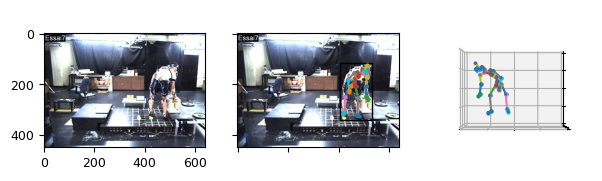

In [ ]:
myfile = f'/content/frames/frame_{350}.jpg'
img = tf.image.decode_image(tf.io.read_file(myfile))
pred = model.detect_poses(img, skeleton='smpl+head_30')
myfig = plot_results(img, pred, joint_names, joint_edges)

myfig.savefig('subplot_plot_0.svg', format='svg', dpi=600)


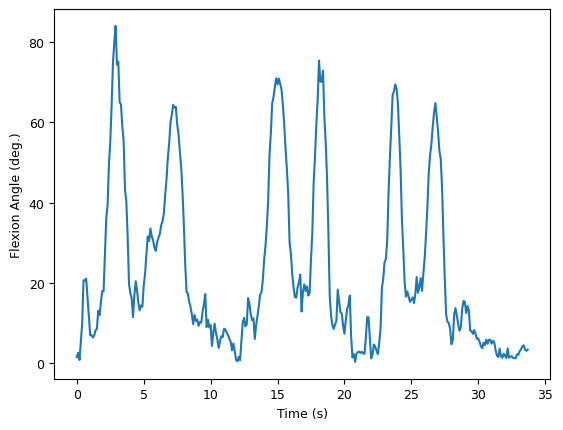

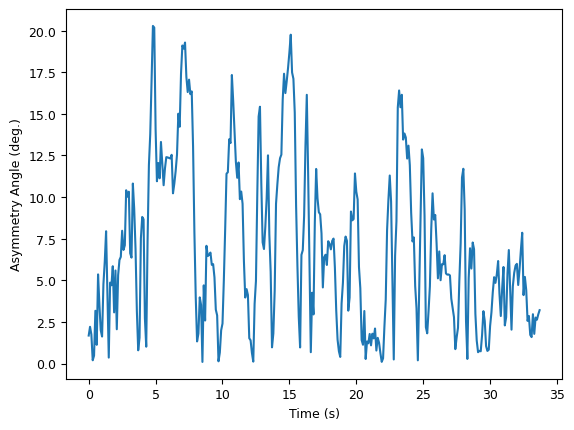

In [ ]:
import matplotlib.pyplot as plt

plt.plot(analysis_results['time'], analysis_results['flex_pose'])
plt.xlabel('Time (s)')
plt.ylabel('Flexion Angle (deg.)')
plt.show()

plt.plot(analysis_results['time'], analysis_results['asymmetry_angle'])
plt.xlabel('Time (s)')
plt.ylabel('Asymmetry Angle (deg.)')
plt.show()


The data from Optotrack is stored on Google Drive. Due to ethical limitations, we are unable to share this data publicly. If you are interested in accessing the data, please contact us.

In [ ]:
import scipy.io
import numpy as np

def find_closest(array, value):
    # Calculate the absolute difference between each element and the value
    abs_diff = np.abs(array - value)

    # Find the index of the minimum absolute difference
    index = np.argmin(abs_diff)

    return index

# Load the .mat file from "optotrack"
folder_path = '/content/drive/MyDrive/integrating new tech/validation/xavier test'
optotrack_file = scipy.io.loadmat(os.path.join(folder_path, 'Optotrak', 'InverseKinematicsResults.mat'))
optotrack_file  = optotrack_file['InverseKinematicsResults']['AnatLandmark'][0][0][0]

optotrack_time = scipy.io.loadmat(os.path.join(folder_path, 'Optotrak', 'ExperimentalData.mat'))
optotrack_time = optotrack_time['ExperimentalData'][0][0]['Time'][0]


In [ ]:
optotrack_joint_info = [
    ['knee'     ,'R',  20,  4],
    ['ankle'    ,'R',  20,  5],
    ['neck'     ,'' ,  1 ,  8],
    ['shoulder' ,'R',  10,  6],
    ['shoulder' ,'L',  10,  7],
    ['head'     ,'' ,  16,  7],
    ['hip'      ,'R',  19, 21],
    ['heel'     ,'R',  22,  1],
    ['toe'      ,'R',  22, 39],
    ['hip'      ,'L',  25, 21],
    ['knee'     ,'L',  26,  4],
    ['ankle'    ,'L',  26,  5],
    ['heel'     ,'L',  28,  1],
    ['toe'      ,'L',  28, 39],
    ['wrist'    ,'R',  33,  3],
    ['elbow'    ,'R',  33,  4],
    ['wrist'    ,'L',  40,  3],
    ['elbow'    ,'L',  40,  4]]
optotrack_joint_connection = [
    [3 ,  6],
    [3 ,  4],
    [3 ,  5],
    [4 , 16],
    [16, 15],
    [5 , 18],
    [18, 17],
    [4 ,  7],
    [5 , 10],
    [7 , 10],
    [7 , 1 ],
    [1 , 2 ],
    [2 , 8 ],
    [8 , 9 ],
    [9 , 2 ],
    [10, 11],
    [11, 12],
    [12, 13],
    [13, 14],
    [14, 12]]


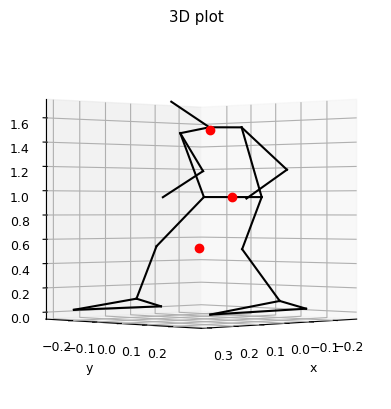

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

time_index = find_closest(optotrack_time, 14.5)

# Make the axes equal
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = np.abs(x_limits[1] - x_limits[0])
    y_range = np.abs(y_limits[1] - y_limits[0])
    z_range = np.abs(z_limits[1] - z_limits[0])

    max_range = np.max([x_range, y_range, z_range])

    x_mid = np.mean(x_limits)
    y_mid = np.mean(y_limits)
    z_mid = np.mean(z_limits)

    ax.set_xlim3d([x_mid - max_range / 2, x_mid + max_range / 2])
    ax.set_ylim3d([y_mid - max_range / 2, y_mid + max_range / 2])
    ax.set_zlim3d([z_mid - max_range / 2, z_mid + max_range / 2])


def plot_optotrack():
  optotrack_clean_segments = []
  # ploting link segment of the optotrack landmark points
  for joint_indx in optotrack_joint_connection:
    indx0 = optotrack_joint_info[joint_indx[0] - 1]
    indx1 = optotrack_joint_info[joint_indx[1] - 1]

    segment0 = optotrack_file[indx0[2] - 1][0][0]
    pnt0 = segment0[indx0[3] - 1][0][:, time_index]/subject_height

    segment1 = optotrack_file[indx1[2] - 1][0][0]
    pnt1 = segment1[indx1[3] - 1][0][:, time_index]/subject_height

    optotrack_clean_segments.append([pnt0, pnt1])

    ax.plot(*zip(pnt0, pnt1), '-k')

  return optotrack_clean_segments

def get_exp_pnt(landmark_name, landmark_side):
  for landmark_info in optotrack_joint_info:
    if (landmark_info[0] == landmark_name) and (landmark_info[1] == landmark_side):
      segment_indx = landmark_info[2] - 1
      pnt_indx =  landmark_info[3] - 1
      mysegment = optotrack_file[segment_indx][0][0]
      mypnt = mysegment[pnt_indx][0]

  return mypnt


mid_shoulder = 0.5*(get_exp_pnt('shoulder', 'L') + get_exp_pnt('shoulder', 'R'))
mid_hip = 0.5*(get_exp_pnt('hip', 'L') + get_exp_pnt('hip', 'R'))
mid_knee = 0.5*(get_exp_pnt('knee', 'L') + get_exp_pnt('knee', 'R'))
mid_hand = 0.5*(get_exp_pnt('wrist', 'L') + get_exp_pnt('wrist', 'R'))

shoulder_pnt_right = get_exp_pnt('shoulder', 'R')
shoulder_pnt_left = get_exp_pnt('shoulder', 'L')

hip_pnt_right = get_exp_pnt('hip', 'R')
hip_pnt_left = get_exp_pnt('hip', 'L')

shoulder_length = get_exp_pnt('shoulder', 'L') - get_exp_pnt('shoulder', 'R')
shoulder_length = np.linalg.norm(shoulder_length, axis = 0)

flex_angle = np.zeros((mid_hip.shape[1]))
asymmetry_angle = np.zeros((mid_hip.shape[1]))
hand_to_hip_distance = np.zeros((mid_hip.shape[1]))
hand_to_shoulder_distance = np.zeros((mid_hip.shape[1]))
for i in range(mid_hip.shape[1]):
  myshoulder = mid_shoulder[:, i]
  myhip = mid_hip[:, i]
  myknee = mid_knee[:, i]
  myhand = mid_hand[:, i]

  shoulder_vector = shoulder_pnt_left[:, i] - shoulder_pnt_right[:, i]
  hip_vector = hip_pnt_left[:, i] - hip_pnt_right[:, i]

  shoulder_vector[2] = 0
  hip_vector[2] = 0

  shoulder_vector = shoulder_vector/np.linalg.norm(shoulder_vector)
  hip_vector = hip_vector/np.linalg.norm(hip_vector)

  asymmetry_angle[i] = np.rad2deg(np.arccos(np.dot(shoulder_vector, hip_vector)))

  # Flexion angle
  v1 = myshoulder - myhip
  v1 = v1/np.linalg.norm(v1)

  v2 = myhip - myknee
  v2 = v2/np.linalg.norm(v2)

  flex_angle[i] = np.rad2deg(np.arccos(np.dot(v1, v2)))

  # Hand distance to hip
  hand_to_hip_distance[i] = np.linalg.norm(myhand - myhip)/shoulder_length[i]

  # Hand to shoulder
  projection_matrix = np.array([1, 1, 0])
  hand_to_shoulder_distance[i] = np.linalg.norm(myhand*projection_matrix - myshoulder*projection_matrix)/shoulder_length[i]

# print(myshoulder)
# print(myhip)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

subject_height = 1.
optotrack_points = np.empty((0, 3))


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('3D plot')
ax.set_box_aspect([1,1,1]) # set aspect ratio to equal
ax.view_init(elev=0, azim=45)

# set_axes_equal(ax)
plot_optotrack()
ax.plot(mid_hip[0, time_index], mid_hip[1, time_index], mid_hip[2, time_index], 'or')
ax.plot(mid_knee[0, time_index], mid_knee[1, time_index], mid_knee[2, time_index], 'or')
ax.plot(mid_shoulder[0, time_index], mid_shoulder[1, time_index], mid_shoulder[2, time_index], 'or')
plt.show()



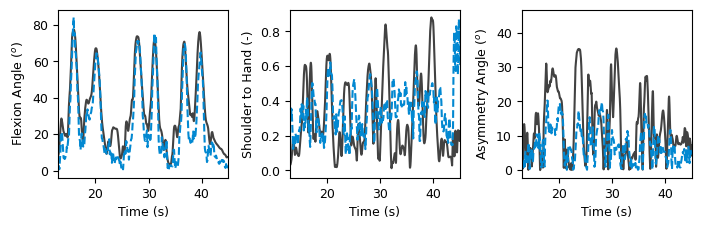

In [ ]:
import matplotlib.pyplot as plt

# plt.rcParams['font.family'] = 'verdana'
plt.rcParams['font.size'] = 9

# Set the plot size
cm = 1/2.54
fig, axs = plt.subplots(1, 3, figsize=(18*cm, 6*cm))

experiment_color = '#424242'
pose_det_color = '#0288d1'

# Flexion angle
axs[0].plot(optotrack_time, flex_angle, '-', color = experiment_color)
axs[0].plot(np.array(analysis_results['time'])+13, analysis_results['flex_pose'], '--', color = pose_det_color)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Flexion Angle ($^o$)')
axs[0].set_xlim(13, 45)

# Shoulder distance
axs[1].plot(optotrack_time, hand_to_shoulder_distance, '-', color = experiment_color)
axs[1].plot(np.array(analysis_results['time'])+13, analysis_results['shoulder_hand_dist'], '--', color = pose_det_color)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Shoulder to Hand (-)')
axs[1].set_xlim(13, 45)

# Asymmetry angle
axs[2].plot(optotrack_time, asymmetry_angle, '-', color = experiment_color)
axs[2].plot(np.array(analysis_results['time'])+13, analysis_results['asymmetry_angle'], '--', color = pose_det_color)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Asymmetry Angle ($^o$)')
axs[2].set_xlim(13, 45)

plt.tight_layout()

plt.savefig('subplot_plot.svg', format='svg', dpi=600)


A function to calcualte spinal loads at based on Ghezelbash et al JB 2016: https://doi.org/10.1016/j.jbiomech.2019.109550

In [ ]:

import pandas as pd


def cal_spinal_loads(inputs):
    # Read proper regressoin table
    file_path = '/content/drive/MyDrive/integrating new tech/Regression Equation Table.xlsx'
    if inputs['F'] > 15:
        xlsx = pd.read_excel(file_path, sheet_name='Flex', header=0)
    else:
        xlsx = pd.read_excel(file_path, sheet_name='Stand', header=0)

    outputs = dict.fromkeys(xlsx.columns[1:].to_list(), 0)
    for spinal_load_type in xlsx.columns[1:].to_list():
        mydf = xlsx.loc[:, spinal_load_type]
        mytemp = np.zeros((xlsx.iloc[:, 0].shape[0], 3))
        for indx, regssion_coef_name in enumerate(xlsx.iloc[:, 0].to_list()):
            mykeys = regssion_coef_name.split(':')
            mycoef = mydf[indx]
            myparam = [inputs[val] for val in mykeys]

            mytemp[indx, 0] = myparam[0]
            if len(myparam) > 1:
                mytemp[indx, 1] = myparam[1]
            else:
                mytemp[indx, 1] = 1.0
            mytemp[indx, 2] = mycoef

        # print()
        outputs[spinal_load_type] = np.abs(np.sum(np.prod(mytemp, axis=1)))
    return(outputs)



Calculate spinal loads based on measured experiments



In [ ]:
# Find intervals when load is carried
def in_intervals(t, input_intervals):
    return np.array([any(x <= elem <= y for x, y in input_intervals) for elem in t]).astype(int)

lifted_load_period = [[15.925, 20.075], [27.85, 31.1], [36.725, 39.6]]
load_intervals_experiment = in_intervals(optotrack_time, lifted_load_period)

spinal_loads_experiment = {'shear': np.zeros(optotrack_time.shape),
                           'comp': np.zeros(optotrack_time.shape)}

for i in range(optotrack_time.shape[0]):
  inputs = {
      'Sex': 0,                               # Male = 0 | Female = 1
      'BH': 176,                              # Height in cm
      'BW': 71,                               # Weight in kg
      'M': 10*load_intervals_experiment[i],   # Hand-load mass in kg
      'A': asymmetry_angle[i],                # Asymmetry angle in deg.
      'F': flex_angle[i],                     # Flexion angle in deg.
      'D': hand_to_shoulder_distance[i]*shoulder_length[0]*100,   # Dsitance of the load from the should joint in cm
      'Constant': 1.0}
  myloads = cal_spinal_loads(inputs)
  spinal_loads_experiment['comp'][i] = myloads['L4-L5_comp']
  spinal_loads_experiment['shear'][i] = myloads['L4-L5_shear']


In [ ]:
# Calculate spinal loads based on estimated kinematics
load_intervals_pose_est = in_intervals(np.array(analysis_results['time'])+13, lifted_load_period)

spinal_loads_pose_est = {'shear': np.zeros(len(analysis_results['time'])),
                         'comp': np.zeros(len(analysis_results['time']))}

for i in range(len(analysis_results['time'])):
  inputs = {
      'Sex': 0,                               # Male = 0 | Female = 1
      'BH': 176,                              # Height in cm
      'BW': 71,                               # Weight in kg
      'M': 10*load_intervals_pose_est[i],    # Hand-load mass in kg
      'A': analysis_results['asymmetry_angle'][i],                # Asymmetry angle in deg.
      'F': analysis_results['flex_pose'][i],                     # Flexion angle in deg.
      'D': analysis_results['shoulder_hand_dist'][i]*shoulder_length[0]*100,   # Dsitance of the load from the should joint in cm
      'Constant': 1.0}
  myloads = cal_spinal_loads(inputs)
  spinal_loads_pose_est['comp'][i] = myloads['L4-L5_comp']
  spinal_loads_pose_est['shear'][i] = myloads['L4-L5_shear']


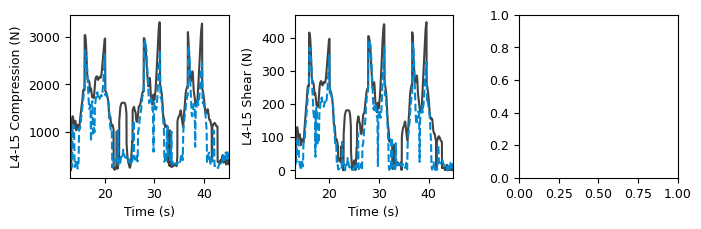

In [ ]:
# Plotting spinal load results
experiment_color = '#424242'
pose_det_color = '#0288d1'

fig, axs = plt.subplots(1, 3, figsize=(18*cm, 6*cm))

for i, load_type in enumerate(['comp', 'shear']):
  axs[i].plot(optotrack_time, spinal_loads_experiment[load_type], '-', color = experiment_color)
  axs[i].plot(np.array(analysis_results['time'])+13, spinal_loads_pose_est[load_type], '--', color = pose_det_color)

  axs[i].set_xlabel('Time (s)')
  if load_type == 'comp':
    axs[i].set_ylabel('L4-L5 Compression (N)')
  else:
    axs[i].set_ylabel('L4-L5 Shear (N)')
  axs[i].set_xlim(13, 45)

# ax[-1].axis('off')

plt.tight_layout()

plt.savefig('subplot_plot_1.svg', format='svg', dpi=600)